In [1]:
## run matlab from python

In [2]:
# !pip install matplotlib

In [3]:
# !pip install scikit-learn==0.20.3

In [4]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle

In [ ]:
# import librosa

In [6]:
cd "/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/NET/timeSeriesViewer/dataRecordingObjects/"

/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/NET/timeSeriesViewer/dataRecordingObjects


In [7]:
eng = matlab.engine.start_matlab() #the engine is set to the current path

In [8]:
# eng.pwd() # make sure good path

In [9]:
bin_fullpath = r'/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/experiment1_109.raw.bin' #NOTE: meta file shoud be with the bin file at the same folder

In [10]:
bin_obj = eng.binaryRecording(bin_fullpath) #NOTE- if fail - make sure you created eng in the rigיt path

In [11]:
startTime_ms = matlab.double([0]) #crate a matlab array (numbers should be doubles)

In [12]:
channels = matlab.double(range(1,2))

In [13]:
time_window_hours = 1
time_window_ms = hours * 60.0 * 60 * 1000

In [14]:
matlab_mat_data = eng.getData(bin_obj, channels, startTime_ms, time_window_ms)

In [15]:
py_mat = np.array(matlab_mat_data) #convert the result to python object

In [16]:
py_mat.shape

(1, 1, 72000000)

In [17]:
# 200000 * (1/20000) 

In [18]:
# dim explain
# py_mat[x][y][z]
# x- channel (acording to the order given to getData)
# y- start_time (acording to the order given to getData) 
# z- voltage (acording to the window given to getData) 

In [19]:
pc_pymat = py_mat[0][0]

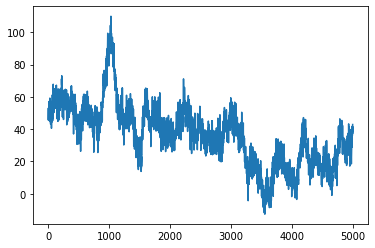

In [20]:
plt.plot(pc_pymat[15000:20000])

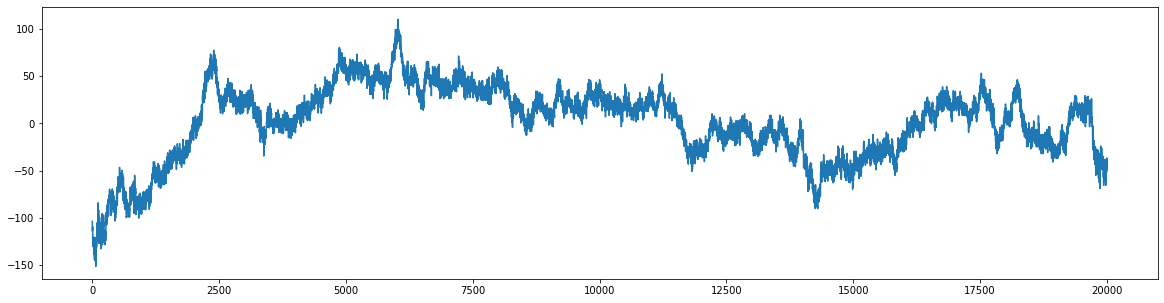

In [21]:
plt.figure(figsize=(20,5))
plt.plot(pc_pymat[10000:30000])

In [22]:
s_pymat = pc_pymat[:20000000]

In [23]:
s_pymat.shape

(20000000,)

In [24]:
#f, t, Zxx = signal.stft(x, fs, nperseg=1000)
# x = the signal (vector of samples) ; fs = sample rate ; nperseg = window (num of samples)
f, t, Zxx = signal.stft(s_pymat, 20000, nperseg=200000, noverlap = 180000)

In [25]:
Zxx.shape

(100001, 1001)

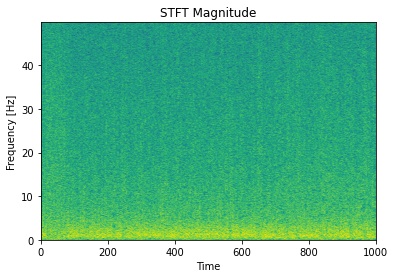

In [26]:
plt.pcolormesh(t[:], f[:500], np.log(np.abs(Zxx[:500,:])), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time')
plt.show()

In [27]:
# cluster after fft
X_t = np.abs(Zxx[:500,]) #data matrix- until 50Hz
X = np.transpose(X_t)

In [30]:
from sklearn.cluster import AffinityPropagation

In [38]:
#there are a lot of deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [39]:
af = AffinityPropagation(preference=-50, max_iter=20000).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

In [ ]:
# # cluster raw data
# # X = np.abs(Zxx[:500,]) #data matrix- until 50Hz
# X_t = np.transpose(s_pymat)

# af = AffinityPropagation(preference=-50, max_iter=200).fit(X_t)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

In [40]:
X_t.shape

(500, 1001)

In [41]:
n_clusters_

813

In [42]:
labels

array([  0,   1,   2, ..., 812, 812, 812])

In [43]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [44]:
X.shape[0]

1001

In [45]:
bandwidth = estimate_bandwidth(X, quantile=0.5)

for i in range(1, round(bandwidth)+1):
    print("------------ " + str(i) + " --------------")
    ms = MeanShift(bandwidth=i)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print(n_clusters_)

------------ 1 --------------
1001
------------ 2 --------------
1001
------------ 3 --------------
1001
------------ 4 --------------
1001
------------ 5 --------------
1001
------------ 6 --------------
966
------------ 7 --------------
834
------------ 8 --------------
630
------------ 9 --------------
470
------------ 10 --------------
392
------------ 11 --------------
345
------------ 12 --------------
257
------------ 13 --------------
162
------------ 14 --------------
91
------------ 15 --------------
33
------------ 16 --------------
6
------------ 17 --------------
2
------------ 18 --------------
2
------------ 19 --------------
1
------------ 20 --------------
1
------------ 21 --------------
1
------------ 22 --------------
1


In [46]:
ms = MeanShift(bandwidth=18)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [47]:
indxes = np.where(labels == 0)
len(indxes[0])

989

In [ ]:
# labels_unique

In [48]:
sub_X = X[indxes[0],:]

In [49]:
sub_X.shape

(989, 500)

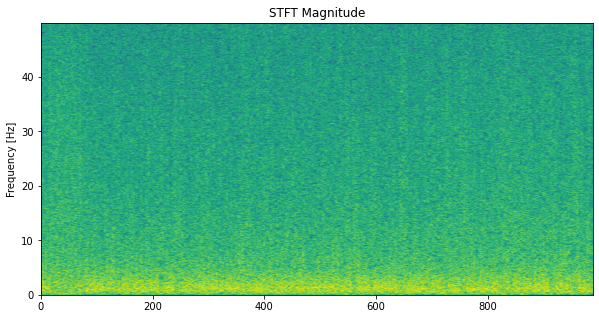

In [50]:
plt.figure(figsize=(sub_X.shape[0] / 100 ,5))
plt.pcolormesh(t[:sub_X.shape[0]], f[:500], np.log(np.transpose(sub_X)), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time')
plt.show()

In [51]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

In [52]:
graph = image.img_to_graph(X)

In [53]:
graph.data = np.exp(-graph.data / graph.data.std())

In [54]:
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')

In [ ]:
# # Take a decreasing function of the gradient: we take it weakly
# # dependent from the gradient the segmentation is close to a voronoi
# graph.data = np.exp(-graph.data / graph.data.std())

# # Force the solver to be arpack, since amg is numerically
# # unstable on this example
# labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
# # label_im = np.full(mask.shape, -1.)
# # label_im[mask] = labels

# plt.matshow(img)
# # plt.matshow(label_im)

In [55]:
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [56]:
indxes = np.where(labels == 4)
len(indxes[0])

0

In [57]:
graph

<500500x500500 sparse matrix of type '<class 'numpy.float64'>'
	with 2499498 stored elements in COOrdinate format>

In [58]:
X.shape

(1001, 500)

In [59]:
pwd

'/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/NET/timeSeriesViewer/dataRecordingObjects'